In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import paddle

from paddlets.datasets.repository import get_dataset
from paddlets.datasets.tsdataset import TSDataset
from paddlets.transform import TimeFeatureGenerator
from paddlets.transform.sklearn_transforms import StandardScaler
from paddlets.models.forecasting import MLPRegressor
from paddlets.models.forecasting import RNNBlockRegressor

from paddlets.metrics import MAE
from paddlets.metrics import MSE

## 1 读取数据

In [3]:
ts = get_dataset("WTH") # 公开数据集，天气数据
ts

                     WetBulbCelsius  Visibility  DryBulbFarenheit  \
date                                                                
2010-01-01 00:00:00           -10.3        10.0                16   
2010-01-01 01:00:00           -10.3        10.0                16   
2010-01-01 02:00:00           -10.3        10.0                16   
2010-01-01 03:00:00           -10.3        10.0                16   
2010-01-01 04:00:00           -10.0        10.0                16   
...                             ...         ...               ...   
2013-12-31 19:00:00             0.0        10.0                32   
2013-12-31 20:00:00             0.0         7.0                30   
2013-12-31 21:00:00             0.0         5.0                30   
2013-12-31 22:00:00             0.0        10.0                30   
2013-12-31 23:00:00            -1.5        10.0                30   

                     DryBulbCelsius  WetBulbFarenheit  DewPointFarenheit  \
date                      

In [4]:
ts.get_target()

                     WetBulbCelsius
date                               
2010-01-01 00:00:00           -10.3
2010-01-01 01:00:00           -10.3
2010-01-01 02:00:00           -10.3
2010-01-01 03:00:00           -10.3
2010-01-01 04:00:00           -10.0
...                             ...
2013-12-31 19:00:00             0.0
2013-12-31 20:00:00             0.0
2013-12-31 21:00:00             0.0
2013-12-31 22:00:00             0.0
2013-12-31 23:00:00            -1.5

[35064 rows x 1 columns]

In [5]:
ts.get_observed_cov()

                     Visibility  DryBulbFarenheit  DryBulbCelsius  \
date                                                                
2010-01-01 00:00:00        10.0                16              -9   
2010-01-01 01:00:00        10.0                16              -9   
2010-01-01 02:00:00        10.0                16              -9   
2010-01-01 03:00:00        10.0                16              -9   
2010-01-01 04:00:00        10.0                16              -9   
...                         ...               ...             ...   
2013-12-31 19:00:00        10.0                32               0   
2013-12-31 20:00:00         7.0                30              -1   
2013-12-31 21:00:00         5.0                30              -1   
2013-12-31 22:00:00        10.0                30              -1   
2013-12-31 23:00:00        10.0                30              -1   

                     WetBulbFarenheit  DewPointFarenheit  DewPointCelsius  \
date                     

In [6]:
ts.get_known_cov()

## 2 数据处理

In [7]:
# 时间类特征引入
time_f = TimeFeatureGenerator(feature_cols = ["month", "weekday", "hour"])
ts = time_f.fit_transform(ts)
ts

                     WetBulbCelsius  Visibility  DryBulbFarenheit  \
date                                                                
2010-01-01 00:00:00           -10.3        10.0                16   
2010-01-01 01:00:00           -10.3        10.0                16   
2010-01-01 02:00:00           -10.3        10.0                16   
2010-01-01 03:00:00           -10.3        10.0                16   
2010-01-01 04:00:00           -10.0        10.0                16   
...                             ...         ...               ...   
2013-12-31 19:00:00             0.0        10.0                32   
2013-12-31 20:00:00             0.0         7.0                30   
2013-12-31 21:00:00             0.0         5.0                30   
2013-12-31 22:00:00             0.0        10.0                30   
2013-12-31 23:00:00            -1.5        10.0                30   

                     DryBulbCelsius  WetBulbFarenheit  DewPointFarenheit  \
date                      

In [8]:
ts.get_known_cov()

                     month  weekday  hour
date                                     
2010-01-01 00:00:00      1        4     0
2010-01-01 01:00:00      1        4     1
2010-01-01 02:00:00      1        4     2
2010-01-01 03:00:00      1        4     3
2010-01-01 04:00:00      1        4     4
...                    ...      ...   ...
2013-12-31 19:00:00     12        1    19
2013-12-31 20:00:00     12        1    20
2013-12-31 21:00:00     12        1    21
2013-12-31 22:00:00     12        1    22
2013-12-31 23:00:00     12        1    23

[35064 rows x 3 columns]

In [9]:
# 拆分数据集
ts_train, ts_val_test = ts.split("2012-03-31 23:00:00")
ts_val, ts_test = ts_val_test.split("2013-02-28 23:00:00")

In [10]:
# 标准化
scaler = StandardScaler()
scaler.fit(ts_train)
ts_train_scaled = scaler.transform(ts_train)
ts_val_scaled = scaler.transform(ts_val)
ts_test_scaled = scaler.transform(ts_test)

## 3 模型训练

In [12]:
# 模型定义
rnn = RNNBlockRegressor(
    in_chunk_len = 24*5,     #历史输入序列长度
    out_chunk_len = 24,      #未来预测序列长度
    sampling_stride = 24,    #采样间隔
    max_epochs=100,          # 最大迭代轮次
    optimizer_params = dict(learning_rate=1e-3),  #优化参数，学习率
    batch_size = 32,         #批量大小
    patience=20              #patience
)

In [13]:
np.random.seed(2023)
paddle.seed(2023)
# 模型训练
rnn.fit(ts_train_scaled, ts_val_scaled)

[2022-11-10 15:21:55,743] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 0.363298| val_0_mae: 0.259822| 0:00:00s
[2022-11-10 15:21:56,221] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.096705| val_0_mae: 0.228090| 0:00:01s
[2022-11-10 15:21:56,684] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.083936| val_0_mae: 0.210965| 0:00:01s
[2022-11-10 15:21:57,185] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.080415| val_0_mae: 0.211120| 0:00:02s
[2022-11-10 15:21:57,732] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.078427| val_0_mae: 0.209158| 0:00:02s
[2022-11-10 15:21:58,230] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.077287| val_0_mae: 0.211983| 0:00:03s
[2022-11-10 15:21:58,728] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.076421| val_0_mae: 0.206052| 0:00:03s
[2022-11-10 15:21:59,177] [paddlets.models.common.callb

## 4 预测与评估

In [14]:
# 单次预测：模型上线，例行预测
res = rnn.predict(ts_val_scaled)
res

                     WetBulbCelsius
2013-03-01 00:00:00       -1.116902
2013-03-01 01:00:00       -1.140365
2013-03-01 02:00:00       -1.157798
2013-03-01 03:00:00       -1.116379
2013-03-01 04:00:00       -1.144197
2013-03-01 05:00:00       -1.182413
2013-03-01 06:00:00       -1.207188
2013-03-01 07:00:00       -1.188643
2013-03-01 08:00:00       -0.992388
2013-03-01 09:00:00       -0.917662
2013-03-01 10:00:00       -0.642903
2013-03-01 11:00:00       -0.584468
2013-03-01 12:00:00       -0.496556
2013-03-01 13:00:00       -0.474909
2013-03-01 14:00:00       -0.516824
2013-03-01 15:00:00       -0.547566
2013-03-01 16:00:00       -0.627948
2013-03-01 17:00:00       -0.599043
2013-03-01 18:00:00       -0.724346
2013-03-01 19:00:00       -0.784895
2013-03-01 20:00:00       -0.839210
2013-03-01 21:00:00       -0.886078
2013-03-01 22:00:00       -0.951548
2013-03-01 23:00:00       -0.946776

In [15]:
# 回测：测试集评估
from paddlets.utils import backtest

metric, pred = backtest(
    data=ts_test_scaled,         #测试数据集
    model=rnn,                   #训练好的模型
    start="2013-11-01 00:00:00", #预测的开始时间
    metric=MAE(),                #评估指标
    predict_window=24,           #预测窗口大小
    stride=24,                   #间隔窗口大小
    return_predicts=True         #是否返回预测值
)

[2022-11-10 15:22:59,088] [paddlets.utils.utils] [WARNING] error occurred while import autots, err: No module named 'ray'
Backtest Progress: 100%|██████████| 61/61 [00:02<00:00, 26.98it/s]


In [16]:
_, ground_truth = ts_test_scaled.split("2013-11-01 00:00:00")

<AxesSubplot:xlabel='date'>

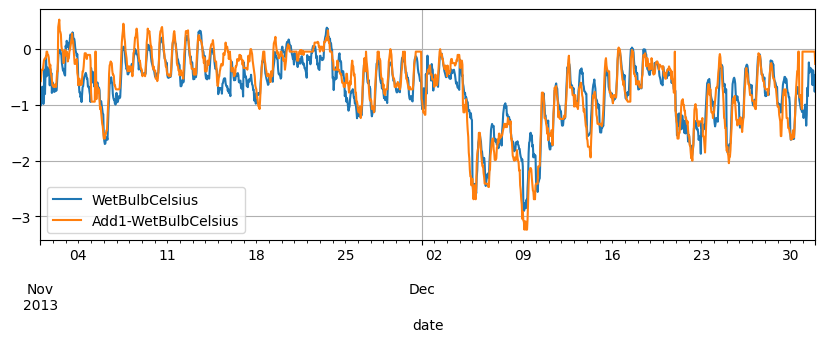

In [17]:
pred.plot(add_data=ground_truth)

In [18]:
metric

{'WetBulbCelsius': 0.20782859500100792}